Here we implement the VideoMAE Feature extraction


In [17]:
!pip install filelock
!pip install huggingface-hub
!pip install numpy
!pip install packaging
!pip install pyyaml
!pip install regex
!pip install requests
!pip install safetensors
!pip install tokenizers
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.2.0-py3-none-any.whl (184 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 65.4 MB/s eta 0:00:0000:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packag

In [18]:
!pip install --upgrade transformers
!pip show transformers 
#needs to be at least version 4.26.0+ to include VideoMAE, so we check with !pip show

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 104.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Name: transformers
Version: 4.49.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/nvanhooijd/.local/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [28]:
import transformers
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification, VideoMAEForPreTraining

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from torch import nn
import torcheval
from torcheval.metrics.functional import multiclass_auprc
from torch.utils.data import Dataset, DataLoader, Subset
import glob
import random
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt

## 1 Load Data

In [3]:
gloss_path = 'data/noor2/CorpusNGT/gloss_split_8frames'

def preprocess_datasubset():
    split_ids = []
    split_labels = []

    with os.scandir(gloss_path) as gloss_folders:
        for gloss_entry in gloss_folders:
            if gloss_entry.is_dir():  # Ensure it's a directory
                gloss_label = gloss_entry.name  # Extract gloss label
                
                with os.scandir(gloss_entry.path) as instance_folders:
                    for instance_entry in instance_folders:
                        if instance_entry.is_dir():  # Ensure it's a directory
                            split_ids.append(instance_entry.path)  # Store full path
                            split_labels.append(gloss_label)  # Store gloss label

    print(len(split_ids), len(split_labels))
    return split_ids, split_labels

split_ids, split_labels = preprocess_datasubset()

100531 100531


In [4]:
catgs = np.unique(split_labels)
print(catgs)
num_classes = len(catgs)
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1

['0-A' '0-B' '0-C' ... 'ZWETEN-A' 'ZWETEN-B' 'ZWITSERLAND']


### 2 Datasets and Transforms

In [5]:
np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

In [6]:
# Choose some of the data transform values

timesteps = 8

data_aug = False
batch_size = 32

h, w =224, 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# h, w = 270, 270
# mean = [0.43216, 0.394666, 0.37645]
# std = [0.22803, 0.22145, 0.216989]

In [7]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [8]:
# define helper functions

def transform_frames(frames):
    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

        # imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor


def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [9]:
train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])


all_ds = VideoDataset(ids= split_ids, labels= split_labels, transform= train_transformer)
print(len(all_ds))
print(all_ds)

100531


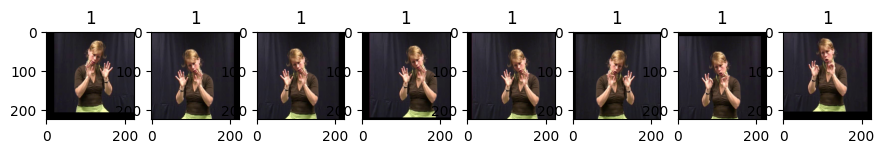

In [10]:
%matplotlib inline

# inspect
imgs, label = all_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

## For image condition, not keypoints
plt.figure(figsize=(12,12))
for ii,img in enumerate(imgs[::1]):
    plt.subplot(2,9,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

### 3 Dataloader

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
print(torch.cuda.is_available())


True


In [13]:
def collate_fn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

# Collate function
def collate_fn2(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs) > 0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs) > 0]
    imgs_tensor = torch.stack(imgs_batch).to(device)  # Move tensors to GPU if available
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch).to(device)
    return imgs_tensor, labels_tensor

all_dl = DataLoader(all_ds, batch_size= batch_size,
                      shuffle=True, collate_fn= collate_fn2)

for xb,yb in all_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 3, 8, 224, 224]) torch.Size([32])


### Testrun

In [37]:
num_frames = 16
video = list(np.random.uniform(0.0, 1,(16, 3, 224, 224)))

processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = VideoMAEForPreTraining.from_pretrained("MCG-NJU/videomae-base")

pixel_values = processor(video, return_tensors="pt").pixel_values

num_patches_per_frame = (model.config.image_size // model.config.patch_size) ** 2
seq_length = (num_frames // model.config.tubelet_size) * num_patches_per_frame
bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool()

outputs = model(pixel_values, bool_masked_pos=bool_masked_pos)
features = outputs.logits
print(features)

tensor([[[ 0.0320,  0.0724,  0.0790,  ...,  0.3149,  0.1251,  0.1961],
         [-0.0093, -0.0122, -0.2366,  ..., -0.1335,  0.0277,  0.1079],
         [-0.0201, -0.0530,  0.0005,  ..., -0.2188, -0.0768, -0.1374],
         ...,
         [-0.3197,  0.1633,  0.1287,  ...,  0.2856,  0.1056, -0.0017],
         [ 0.1593, -0.1954, -0.1797,  ...,  0.0560,  0.0373,  0.0639],
         [-0.0472,  0.2162,  0.0513,  ..., -0.4557, -0.2069, -0.0529]]],
       grad_fn=<ViewBackward0>)


In [38]:
## Here a we implement the VideoMAE network from the model page and test it on one random video and it works!

"""
Implementation of the VIDEOMAE model finetuned on the kinetics dataset from https://huggingface.co/MCG-NJU/videomae-base-finetuned-kinetics
"""

video = list(np.random.rand(16, 3, 224, 224))  ## this video would be 16 frames with 3 channels and 224 by 224 height and width

processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

inputs = processor(video, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
print()
print(logits)
print(outputs)

Predicted class: dancing ballet

tensor([[ 0.1136,  0.9234, -0.2557, -0.7710, -0.6061,  0.5372,  0.5820, -0.8431,
         -0.5542, -1.0932,  0.0470, -0.0030, -0.2336, -0.5399,  0.2307, -0.5674,
          0.5955, -0.7999,  0.6993,  0.3872, -0.0918, -0.8024,  0.2212, -0.6779,
          0.0509, -0.4848, -0.2093,  0.4684, -0.3761, -0.1872, -0.3976,  0.4219,
         -0.1680, -0.8188,  0.1440, -0.6344,  0.1202,  0.1261, -0.7865, -0.8387,
          0.3728, -0.3066,  0.1204,  0.3597, -0.1570, -0.2654, -0.2105, -0.4662,
          0.5040,  0.5988,  0.0444, -0.4125, -0.2122, -0.6088, -0.3176,  0.2636,
          0.2334, -0.6386, -0.7939,  0.3077, -0.2017, -0.6013, -0.9748, -0.1898,
         -0.7858, -0.3010, -0.9193, -0.1774,  0.4157,  0.7489,  0.0197, -0.5820,
         -0.9481, -0.7397, -0.2167,  0.0513, -0.1606,  0.5137,  0.1323,  0.4607,
          0.1488, -0.4348, -0.4175, -0.1540,  1.2531, -0.2059,  0.2087,  0.2126,
          0.1889, -0.5819, -0.7496, -0.1720, -0.3562,  0.2845, -0.2322, -0.9

### Run for all videos

In [56]:
import os
import torch
from PIL import Image
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from tqdm import tqdm

# Function to load frames from a directory
def load_video_from_directory(video_dir, target_size=(224, 224)):
    frames = []
    
    # List all image files in the directory and sort them (assuming frame names are in order)
    frame_files = sorted(os.listdir(video_dir))
    
    for frame_file in frame_files:
        if frame_file.endswith(('.jpg', '.png', '.jpeg')):  # Process image files
            frame_path = os.path.join(video_dir, frame_file)
            frame = Image.open(frame_path).convert("RGB")  # Open as RGB image
            frame = frame.resize(target_size)  # Resize to target size (224x224)
            frames.append(frame)
            frames.append(frame)
            
    return frames

# Initialize VideoMAE processor and model
processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available
model.eval()  # Set the model to evaluation mode to ensure consistent model behavior

# Path to the parent directory containing multiple video frame folders
parent_dir = "data/noor2/CorpusNGT/gloss_split_8frames"  # Replace with your actual path


# Remove all and start over

for gloss_name in tqdm(sorted(os.listdir(parent_dir))):
    gloss_dir = os.path.join(parent_dir, gloss_name)
    for video_name in sorted(os.listdir(gloss_dir)):
        video_dir = os.path.join(gloss_dir, video_name)
        
        if os.path.isdir(video_dir):  # Ensure it's a directory

            save_path = f"{parent_dir}/{gloss_name}/{video_name}/VideoMAE_Features.pt"
            os.remove(save_path) 

In [64]:
# Iterate over each subdirectory (each representing a video)
for gloss_name in tqdm(sorted(os.listdir(parent_dir))):
    gloss_dir = os.path.join(parent_dir, gloss_name)
    for video_name in sorted(os.listdir(gloss_dir)):
        video_dir = os.path.join(gloss_dir, video_name)
        
        if os.path.isdir(video_dir):  # Ensure it's a directory
            #print(f"Processing video: {video_name}")
            video_frames = load_video_from_directory(video_dir)
            
            if not video_frames:
                print(f"Skipping {video_name} (no valid frames found).")
                continue
            
            inputs = processor(video_frames, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
    
            #predicted_class_idx = logits.argmax(-1).item()
            #print(f"Predicted class for {video_name}: {model.config.id2label[predicted_class_idx]}")

            # Save features
            logits = logits.half().squeeze()
            save_path = f"{parent_dir}/{gloss_name}/{video_name}/VideoMAE_Features.npz"

            feature_array = logits.cpu().numpy()  # Convert to NumPy
            np.savez_compressed(save_path, features=feature_array)
            
            #torch.save(features_half.cpu().squeeze(), save_path, _use_new_zipfile_serialization=True)
            #print(f"Features saved for {video_name} at {save_path}")

100%|██████████| 3780/3780 [2:21:12<00:00,  2.24s/it]    


In [65]:
## Test that the features saved properly

#loaded_features = torch.load(f"{parent_dir}/0-A/0/VideoMAE_Features.pt")

loaded_features = np.load(f"{parent_dir}/0-A/0/VideoMAE_Features.npz")["features"]
loaded_features = torch.tensor(loaded_features)  # Convert back to torch if needed

print(loaded_features)
print(loaded_features.shape)

tensor([ 1.8616e-01, -5.2734e-01,  7.1240e-01, -1.6357e+00,  7.9541e-01,
         5.1367e-01,  1.2158e+00,  1.2393e+00,  1.9373e-01, -5.1514e-01,
        -1.6689e+00,  1.5552e-01,  2.1797e+00,  7.3828e-01,  4.5557e-01,
        -1.0974e-01, -2.4451e-01, -1.4326e+00,  5.1611e-01,  3.1006e-01,
        -1.2031e+00,  3.9727e+00,  8.6914e-01,  3.9990e-01,  1.1514e+00,
        -1.0361e+00, -2.8345e-01,  1.0352e-01, -4.4482e-01, -6.0986e-01,
        -9.1553e-01,  1.5762e+00, -5.2490e-01, -7.3535e-01,  3.2739e-01,
        -4.6680e-01, -9.7070e-01,  3.6348e+00, -7.6025e-01, -1.4082e+00,
         6.2500e-02, -5.7861e-01,  7.1631e-01,  4.3311e-01, -1.3984e+00,
         4.8340e-01,  9.2102e-02, -5.5225e-01,  7.7100e-01,  2.5000e-01,
         2.5195e-01, -1.9788e-01,  6.5918e-02,  3.0762e-01, -2.1777e-01,
        -1.3306e-01,  1.6174e-01, -5.8643e-01, -1.0361e+00, -3.0957e-01,
         3.7378e-01, -9.7534e-02, -1.5742e+00,  5.2002e-01, -8.5571e-02,
        -9.2236e-01, -8.0762e-01,  2.2461e-01,  3.2